<h1><b><i>TABULATOR Bone Topology Analysis and Segmentation</i></b></h1>

All the dependancy

Download dependancy

In [1]:
!pip install numpy
!pip install opencv-python
!pip install scipy
!pip install pandas
!pip install scikit-image

Run Dependancy

In [2]:
import os
import cv2
import random
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.feature import corner_peaks
from scipy.ndimage import convolve, label, center_of_mass
from skimage.morphology import skeletonize
from collections import deque
from typing import List, Tuple, Dict
from scipy.ndimage import binary_hit_or_miss
from scipy.ndimage import distance_transform_edt, convolve, label, center_of_mass
from skimage.graph import route_through_array

Set the input images

File path upload status 'OK'.
final image:  [[[106 106 106]
  [ 96  96  96]
  [ 85  85  85]
  ...
  [197 197 197]
  [202 202 202]
  [204 204 204]]

 [[ 90  90  90]
  [ 79  79  79]
  [ 71  71  71]
  ...
  [191 191 191]
  [203 203 203]
  [208 208 208]]

 [[ 79  79  79]
  [ 66  66  66]
  [ 57  57  57]
  ...
  [178 178 178]
  [194 194 194]
  [203 203 203]]

 ...

 [[ 26  26  26]
  [ 26  26  26]
  [ 24  24  24]
  ...
  [  9   9   9]
  [ 12  12  12]
  [ 16  16  16]]

 [[ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  ...
  [ 13  13  13]
  [ 14  14  14]
  [ 16  16  16]]

 [[ 18  18  18]
  [ 21  21  21]
  [ 21  21  21]
  ...
  [ 14  14  14]
  [ 14  14  14]
  [ 17  17  17]]]


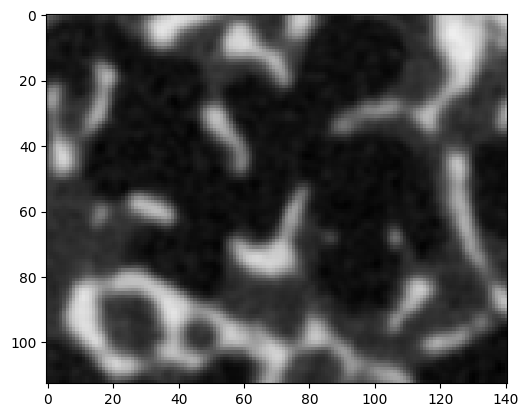

In [3]:
input_image = f"../ctrl-1-1.stack image/ctrl_1_trab.._Raw import  W0.00 L0.00_020.tiff" #adjust your image path

# set image
#check the path validation
if not os.path.exists(input_image):
    print("File does not exist.")
else:
    print("File path upload status 'OK'.")
    image = cv2.imread(input_image)
    if image is None:
        print("Unable to read the image.")
    else:
        print("final image: ", image)
        plt.imshow(image)


Set the output file path

In [4]:
#base on need you can change the file path

os.makedirs("Single_image", exist_ok=True) #this is the file where store all the output files

save_resize_image = f"Single_image/resize_image.png"
save_binary_image = f"Single_image/binary_image.png"
save_skeleton_image = f"Single_image/skeleton_image.png"
save_node_image = f"Single_image/node_image.png"
save_node_csv = f"Single_image/node_image.csv"
save_circle_image = f"Single_image/circle_image.png"
save_circle_csv = f"Single_image/circle_image.csv"
save_ellipse_image = f"Single_image/ellipse_image.png"
save_ellipse_csv = f"Single_image/ellipse_image.csv"
save_width_image = f"Single_image/width_image.png"
save_width_csv = f"Single_image/width_image.csv"
save_width_shape_csv = f"Single_image/width_image_shape.csv"
save_volume = f"Single_image/volume.csv"
save_summary = f"Single_image/summary.csv"

Resize the image

Text(0.5, 1.0, 'INTER_LANCZOS4')

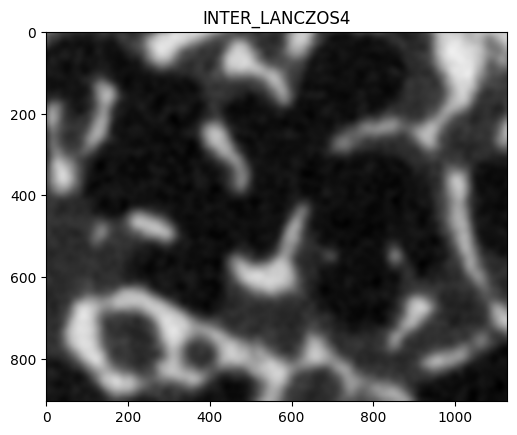

In [5]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape
scale = 8
methods = [cv2.INTER_LANCZOS4]
titles = ["INTER_LANCZOS4"] 

for i in range(len(methods)):
    resized = cv2.resize(img, (w * scale, h * scale), interpolation=methods[i])
    if i == 0:
        best_resize = resized

plt.imshow(best_resize)
plt.title(titles[0])


In [6]:
order = input("Enter 'Save' for save the image Other wise press any things. -> ")
if(order.lower() == "save"):
    cv2.imwrite(save_resize_image, cv2.cvtColor(best_resize, cv2.COLOR_RGB2BGR))

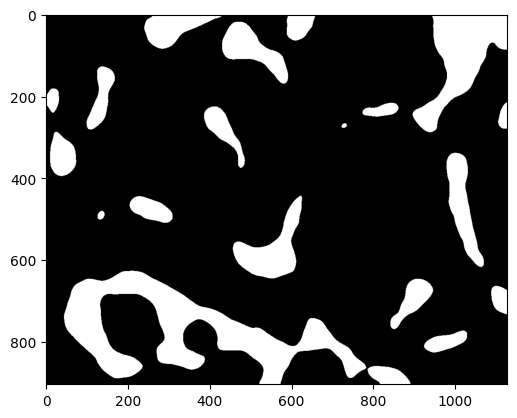

In [7]:
#binary threshold function
gray = cv2.cvtColor(best_resize, cv2.COLOR_BGR2GRAY)
mat = np.array(gray) / 255.0
mat = np.where(mat < 0.45, 0, 1) # Here 0.45 is the threshold value. It's set as par you need between 0.3 - 0.6
binary_image = (mat * 255).astype(np.uint8)
plt.imshow(binary_image, cmap='gray')

In [8]:
order = input("Enter 'Save' for save the image Other wise press any things. -> ")
if(order.lower() == "save"):
    cv2.imwrite(save_binary_image, cv2.cvtColor(binary_image, cv2.COLOR_RGB2BGR))

Create Skeletonise and Node Image and Data

True

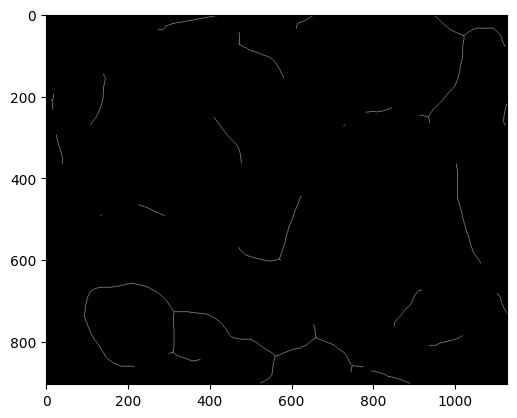

In [9]:
# skeletonise image
skeletonize_image = skeletonize(binary_image).astype(np.uint8)

plt.imshow(skeletonize_image, cmap="gray")
cv2.imwrite(save_skeleton_image, cv2.cvtColor(skeletonize_image, cv2.COLOR_RGB2BGR))

In [10]:
def neighbour_count(skel: np.ndarray) -> np.ndarray:
    # Create a 3x3 kernel to count neighbors around each pixel
    kernel = np.ones((3, 3), np.uint8)
    # Convolve the skeleton image with the kernel to count neighbors for each pixel
    # Subtract the pixel itself to get only the count of its neighbors
    return convolve(skel, kernel, mode="constant", cval=0) - skel

In [11]:
def find_connections(skel: np.ndarray, nodes: List[Tuple[int, int]], max_distance: int = 100) -> Dict[int, List[int]]:
    """
    Finds connections between nodes in a skeletonized image.

    Args:
        skel: Skeletonized binary image (2D numpy array).
        nodes: List of node coordinates (row, col).
        max_distance: Maximum search distance for connections.

    Returns:
        Dictionary mapping node index to a list of connected node indices.
    """
    # Map node positions to their indices for quick lookup
    node_pos_to_index = {pos: idx for idx, pos in enumerate(nodes)}
    # Initialize connections dictionary for each node
    connections = {i: [] for i in range(len(nodes))}
    h, w = skel.shape
    # Iterate over each node
    for i, (sr, sc) in enumerate(nodes):
        visited = set()
        # Use BFS to explore skeleton from the current node
        queue = deque([(sr, sc, 0)])
        while queue:
            r, c, d = queue.popleft()
            # Stop searching if max_distance exceeded
            if d > max_distance:
                continue
            # If another node is found, record the connection
            if (r, c) in node_pos_to_index and node_pos_to_index[(r, c)] != i:
                j = node_pos_to_index[(r, c)]
                if j not in connections[i]:
                    connections[i].append(j)
                continue
            visited.add((r, c))
            # Explore 8-connected neighbors
            for dr in [-1, 0, 1]:
                for dc in [-1, 0, 1]:
                    if dr == 0 and dc == 0:
                        continue
                    nr, nc = r + dr, c + dc
                    # Check bounds and if pixel is part of skeleton and not visited
                    if 0 <= nr < h and 0 <= nc < w and skel[nr, nc] and (nr, nc) not in visited:
                        queue.append((nr, nc, d + 1))
    return connections

In [12]:
def find_endpoints(skel: np.ndarray) -> List[Tuple[int, int]]:
    """
    Find endpoints in a skeletonized image.

    Args:
        skel: Skeletonized binary image (2D numpy array).

    Returns:
        List of coordinates (row, col) for endpoints.
    """
    # Count the number of neighbors for each pixel in the skeleton
    deg = neighbour_count(skel)
    # Endpoints are skeleton pixels with exactly one neighbor
    return [tuple(p) for p in np.argwhere((skel == 1) & (deg == 1))]

In [13]:
def neighbour_count(skel: np.ndarray) -> np.ndarray:
    # Create a 3x3 kernel to count the number of neighbors for each pixel
    kernel = np.ones((3, 3), np.uint8)
    # Convolve the skeleton image with the kernel to get neighbor counts
    # Subtract the pixel itself to exclude it from its own neighbor count
    return convolve(skel, kernel, mode="constant", cval=0) - skel

In [14]:
def euclidean_distance(p: Tuple[int, int], q: Tuple[int, int]) -> float:
    """
    Calculate the Euclidean distance between two points.

    Args:
        p: First point as (row, col).
        q: Second point as (row, col).

    Returns:
        Euclidean distance as a float.
    """
    return float(np.hypot(p[0] - q[0], p[1] - q[1]))

In [15]:
def find_nodes(skel: np.ndarray) -> List[Tuple[int, int]]:
    # Calculate the degree (number of neighbors) for each pixel in the skeleton
    deg = neighbour_count(skel)
    # Identify node pixels: skeleton pixels with degree >= 3 (branch/junction points)
    node_mask = (skel == 1) & (deg >= 3)
    # Label connected node regions
    lbl, n_comp = label(node_mask)
    # Compute the centroid of each labeled node region
    centroids = center_of_mass(node_mask, lbl, range(1, n_comp + 1))
    # Return centroids as integer coordinates (row, col)
    return [(int(round(r)), int(round(c))) for r, c in centroids]

In [16]:
def compute_distances_from_connections(
    nodes: List[Tuple[int, int]], 
    connections: Dict[int, List[int]]
) -> List[Tuple[int, int, int, int, int, int, float]]:
    """
    Compute distances between connected nodes.

    Args:
        nodes: List of node coordinates (row, col).
        connections: Dictionary mapping node index to list of connected node indices.

    Returns:
        List of tuples: (Node1_ID, Node1_row, Node1_col, Node2_ID, Node2_row, Node2_col, Distance)
    """
    result = []
    visited = set()  # Track processed node pairs to avoid duplicates
    for i, neighbors in connections.items():
        r1, c1 = nodes[i]
        for j in neighbors:
            # Skip if this pair has already been processed
            if (i, j) in visited or (j, i) in visited:
                continue
            r2, c2 = nodes[j]
            d = euclidean_distance((r1, c1), (r2, c2))  # Calculate Euclidean distance
            result.append((i + 1, r1, c1, j + 1, r2, c2, d))
            visited.add((i, j))  # Mark this pair as processed
    return result


In [17]:
def overlay_skeleton_nodes(img_gray: np.ndarray, skel: np.ndarray, nodes: List[Tuple[int, int]], endpoints: List[Tuple[int, int]]) -> np.ndarray:
    out = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    ys, xs = np.where(skel)
    out[ys, xs] = (0, 0, 255)
    for node_id, (r, c) in enumerate(nodes, 1):
        cv2.circle(out, (c, r), 3, (0, 255, 0), -1)
        cv2.putText(out, str(node_id), (c + 6, r - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    for idx, (r, c) in enumerate(endpoints):
        cv2.circle(out, (c, r), 3, (255, 0, 0), -1)
        label = f"e{idx}"
        cv2.putText(out, label, (c + 6, r - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    return out


Plot only skeleton over binary image

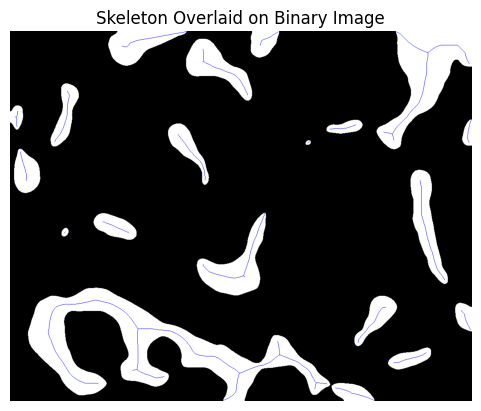

🖼️ Skeleton-only overlay image saved.


In [18]:
# Create a skeleton overlay on binary image only (no nodes or endpoints)
def overlay_skeleton_only(binary_img: np.ndarray, skeleton_img: np.ndarray) -> np.ndarray:
    overlaid = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
    ys, xs = np.where(skeleton_img)
    overlaid[ys, xs] = (0, 0, 255)  # Red for skeleton
    return overlaid

# Generate the overlay image
skeleton_only_image = overlay_skeleton_only(binary_image, skeletonize_image)

# Display the image
plt.imshow(skeleton_only_image)
plt.title("Skeleton Overlaid on Binary Image")
plt.axis("off")
plt.show()

# Optional: save if needed
cv2.imwrite("Single_image/skeleton_overlay_only.png", skeleton_only_image)
print("🖼️ Skeleton-only overlay image saved.")


Node, Endpoint detection and CSV generation

🔍 Nodes Found: [(52, 1019), (74, 473), (209, 15), (251, 933), (598, 569), (727, 312), (791, 658), (827, 310), (835, 559), (859, 747)]
🔍 Endpoints Found: [(0, 429), (1, 944), (2, 654), (35, 610), (36, 273), (44, 471), (75, 470), (79, 1121), (146, 140), (156, 579), (195, 19), (210, 12), (216, 1126), (229, 844), (233, 17), (240, 780), (246, 912), (252, 410), (266, 937), (270, 109), (270, 731), (272, 1121), (273, 726), (295, 25), (364, 476), (365, 39), (365, 1001), (444, 622), (466, 226), (490, 135), (493, 132), (493, 290), (570, 471), (600, 573), (608, 1061), (674, 917), (682, 1102), (730, 1125), (758, 653), (761, 849), (785, 1016), (810, 936), (829, 299), (844, 376), (861, 215), (862, 774), (871, 794), (874, 744), (901, 523), (902, 888)]
🔗 Node Connections: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [7], 6: [8], 7: [5], 8: [6], 9: []}
📏 Node Distances: [(6, 727, 312, 8, 827, 310, 100.0199980003999), (7, 791, 658, 9, 835, 559, 108.33743581975715)]
✅ Node + Endpoint Data Saved to CSV → Single_

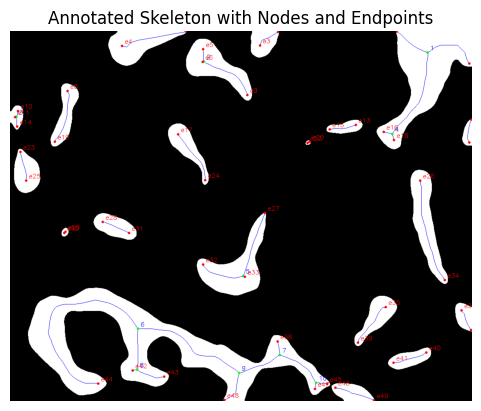

In [19]:
# Find Nodes and Endpoints from Skeleton
nodes = find_nodes(skeletonize_image)
endpoints = find_endpoints(skeletonize_image)
connections = find_connections(skeletonize_image, nodes)
distances = compute_distances_from_connections(nodes, connections)

# Debug Prints
print("🔍 Nodes Found:", nodes)
print("🔍 Endpoints Found:", endpoints)
print("🔗 Node Connections:", connections)
print("📏 Node Distances:", distances)

# Match Endpoints to Nearest Nodes
endpoint_distances = []
used_node_ids = set()
for idx, (er, ec) in enumerate(endpoints):
    min_dist, nearest = float("inf"), -1
    for i, (nr, nc) in enumerate(nodes):
        d = euclidean_distance((er, ec), (nr, nc))
        if d < min_dist:
            min_dist, nearest = d, i
    if nearest != -1:
        endpoint_distances.append((nearest + 1, nodes[nearest], f"e{idx}", (er, ec), min_dist))
        used_node_ids.add(nearest + 1)

# Prepare CSV Rows
connected_node_ids = {i for i, *_ in distances}
rows = [['Node1_ID', 'Coord1', 'Node2_ID', 'Coord2', 'Distance', 'End_point', 'E_Coord', 'E_Distance']]

for (i, r1, c1, j, r2, c2, d) in distances:
    match = next((ep for ep in endpoint_distances if ep[0] == i), None)
    if match:
        _, _, label, (er, ec), ed = match
        rows.append([i, f"({r1},{c1})", j, f"({r2},{c2})", f"{d:.5f}", label, f"({er},{ec})", f"{ed:.5f}"])
    else:
        rows.append([i, f"({r1},{c1})", j, f"({r2},{c2})", f"{d:.5f}", 'null', 'null', 'null'])

# Add unconnected nodes with endpoint info
for i, (r, c) in enumerate(nodes, 1):
    if i not in connected_node_ids:
        match = next((ep for ep in endpoint_distances if ep[0] == i), None)
        if match:
            _, _, label, (er, ec), ed = match
            rows.append([i, f"({r},{c})", 'null', 'null', 'null', label, f"({er},{ec})", f"{ed:.5f}"])

# Save to CSV
df_out = pd.DataFrame(rows[1:], columns=rows[0])
df_out.to_csv(save_node_csv, index=False)
print(f"✅ Node + Endpoint Data Saved to CSV → {save_node_csv}")

# Annotate and Save Visualization Image
out_img = overlay_skeleton_nodes(binary_image, skeletonize_image, nodes, endpoints)
plt.imshow(out_img, cmap="gray")
plt.title("Annotated Skeleton with Nodes and Endpoints")
plt.axis("off")
cv2.imwrite(save_node_image, out_img)
print(f"🖼️ Annotated Image Saved to → {save_node_image}")


In [20]:
# Load binary image (already saved previously)
bw = cv2.imread(save_binary_image, cv2.IMREAD_GRAYSCALE)
bw = (bw > 0).astype(np.uint8)  # ensure binary (0 or 1)
shape_name = os.path.splitext(os.path.basename(save_binary_image))[0]

In [21]:
from scipy.ndimage import label
# Label connected components
labeled, num_shapes = label(bw)
out_img = cv2.cvtColor((bw * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

In [22]:
node_data = []
node_id_counter = 1  # Global node ID across all shapes

print(f"🔎 Found {num_shapes} shapes in {shape_name}")

🔎 Found 20 shapes in binary_image


In [23]:
for shape_id in range(1, num_shapes + 1):
    # Extract the shape
    mask = (labeled == shape_id).astype(np.uint8)

    # Skeletonize the shape
    skeleton = skeletonize(mask).astype(np.uint8)

    # Find nodes
    deg = convolve(skeleton, np.ones((3, 3), np.uint8), mode='constant', cval=0) - skeleton
    node_mask = (skeleton == 1) & (deg >= 3)
    lbl, n_comp = label(node_mask)
    centroids = center_of_mass(node_mask, lbl, range(1, n_comp + 1))
    nodes = [(int(round(r)), int(round(c))) for r, c in centroids]

    # Find endpoints
    endpoint_mask = (skeleton == 1) & (deg == 1)
    endpoints = [tuple(p) for p in np.argwhere(endpoint_mask)]

    print(f"  ▶ Shape {shape_id}: {len(nodes)} nodes, {len(endpoints)} endpoints")

    # Draw skeleton
    ys, xs = np.where(skeleton)
    out_img[ys, xs] = (0, 0, 255)

    # Distance Transform for geodesic radius
    binary_255 = (mask * 255).astype(np.uint8)
    dist_map = distance_transform_edt((binary_255 > 0).astype(np.uint8))

    # Draw nodes
    for idx, (r, c) in enumerate(nodes):
        radius = dist_map[r, c]
        node_data.append({
            'shape_name': shape_name,
            'shape_id': shape_id,
            'node_id': node_id_counter,
            'x': c,
            'y': r,
            'radius': radius
        })

        # Draw circles
        cv2.circle(out_img, (c, r), int(radius), (0, 255, 0), 2)
        cv2.circle(out_img, (c, r), 5, (0, 255, 0), -1)
        cv2.putText(out_img, str(node_id_counter), (c + 8, r - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 1)
        node_id_counter += 1

    # Draw endpoints
    for ep_idx, (r, c) in enumerate(endpoints):
        label_txt = chr(ord('A') + ep_idx)
        cv2.circle(out_img, (c, r), 5, (255, 0, 0), -1)
        cv2.putText(out_img, label_txt, (c + 8, r - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1)

    # Label shape ID
    ys_s, xs_s = np.where(mask)
    if len(xs_s) > 0 and len(ys_s) > 0:
        cx, cy = int(np.mean(xs_s)), int(np.mean(ys_s))
        cv2.putText(out_img, f'S{shape_id}', (cx - 10, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)

  ▶ Shape 1: 0 nodes, 2 endpoints
  ▶ Shape 2: 0 nodes, 2 endpoints
  ▶ Shape 3: 2 nodes, 4 endpoints
  ▶ Shape 4: 1 nodes, 3 endpoints
  ▶ Shape 5: 0 nodes, 2 endpoints
  ▶ Shape 6: 1 nodes, 3 endpoints
  ▶ Shape 7: 0 nodes, 2 endpoints
  ▶ Shape 8: 0 nodes, 2 endpoints
  ▶ Shape 9: 0 nodes, 2 endpoints
  ▶ Shape 10: 0 nodes, 2 endpoints
  ▶ Shape 11: 0 nodes, 2 endpoints
  ▶ Shape 12: 0 nodes, 2 endpoints
  ▶ Shape 13: 1 nodes, 3 endpoints
  ▶ Shape 14: 0 nodes, 2 endpoints
  ▶ Shape 15: 0 nodes, 2 endpoints
  ▶ Shape 16: 5 nodes, 7 endpoints
  ▶ Shape 17: 0 nodes, 2 endpoints
  ▶ Shape 18: 0 nodes, 2 endpoints
  ▶ Shape 19: 0 nodes, 2 endpoints
  ▶ Shape 20: 0 nodes, 2 endpoints


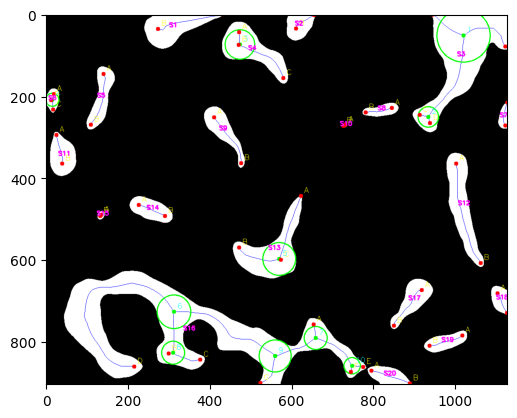

In [24]:
plt.imshow(out_img, cmap="gray")

In [25]:
# Save image and CSV
cv2.imwrite(save_circle_image, out_img)
print(f"🖼️ Saved annotated circle image → {save_circle_image}")

if node_data:
    df = pd.DataFrame(node_data)
    print(df)
    df.to_csv(save_circle_csv, index=False)
    print(f"✅ Saved {len(node_data)} node entries to CSV → {save_circle_csv}")
else:
    print("⚠️ No nodes detected.")

🖼️ Saved annotated circle image → Single_image/circle_image.png
     shape_name  shape_id  node_id     x    y     radius
0  binary_image         3        1  1019   52  65.795137
1  binary_image         3        2   933  251  25.000000
2  binary_image         4        3   473   74  36.000000
3  binary_image         6        4    15  209  16.492423
4  binary_image        13        5   569  598  40.162171
5  binary_image        16        6   312  727  41.231056
6  binary_image        16        7   658  791  28.442925
7  binary_image        16        8   310  827  28.284271
8  binary_image        16        9   559  835  39.000000
9  binary_image        16       10   747  859  20.248457
✅ Saved 10 node entries to CSV → Single_image/circle_image.csv


In [26]:
def angle_between(p1, p2):
    dy = p2[0] - p1[0]
    dx = p2[1] - p1[1]
    return np.degrees(np.arctan2(dy, dx)) % 180


In [27]:
def midpoint(p1, p2):
    return ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)

In [28]:

def euclidean_dist(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

In [29]:
# Load binary image
bw = cv2.imread(save_binary_image, cv2.IMREAD_GRAYSCALE)
bw = (bw > 0).astype(np.uint8)
shape_name = os.path.splitext(os.path.basename(save_binary_image))[0]
labeled, num_shapes = label(bw)
out_img = cv2.cvtColor((bw * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

In [30]:

# Skeletonize once globally
skel = skeletonize(bw).astype(np.uint8)

In [31]:
# Find all nodes and endpoints
deg = convolve(skel, np.ones((3, 3), np.uint8), mode='constant', cval=0) - skel
node_mask = (skel == 1) & (deg >= 3)
lbl, n_comp = label(node_mask)
centroids = center_of_mass(node_mask, lbl, range(1, n_comp + 1))
nodes = [(int(round(r)), int(round(c))) for r, c in centroids]

In [32]:
endpoint_mask = (skel == 1) & (deg == 1)
endpoints = [tuple(p) for p in np.argwhere(endpoint_mask)]

print(f"  Found {len(nodes)} nodes and {len(endpoints)} endpoints in {shape_name}")
print(f"  Detected {num_shapes} shapes in image.")

  Found 10 nodes and 50 endpoints in binary_image
  Detected 20 shapes in image.


In [33]:
# Draw skeleton
ys, xs = np.where(skel)
out_img[ys, xs] = (0, 0, 255)

In [34]:
# Draw all nodes and endpoints
for r, c in nodes:
    cv2.circle(out_img, (c, r), 3, (0, 255, 0), -1)
for r, c in endpoints:
    cv2.circle(out_img, (c, r), 3, (255, 0, 0), -1)

In [35]:

# Begin ellipse fitting
ellipse_data = []
global_pair_id = 1
total_possible_pairs = 0

In [36]:
for shape_id in range(1, num_shapes + 1):
    mask = (labeled == shape_id)
    region_nodes = [p for p in nodes if mask[p]]
    region_ends = [p for p in endpoints if mask[p]]
    all_points = region_nodes + region_ends
    visited = set()

    print(f"    ▶ Shape {shape_id}: {len(region_nodes)} nodes, {len(region_ends)} endpoints")

    for p1 in all_points:
        if p1 in visited:
            continue
        candidates = [p2 for p2 in all_points if p2 != p1 and (p1, p2) not in visited and (p2, p1) not in visited]
        if not candidates:
            continue
        p2 = min(candidates, key=lambda x: euclidean_dist(p1, x))

        mid = midpoint(p1, p2)
        major = euclidean_dist(p1, p2) / 2
        minor = max(3, major * 0.5)
        angle = angle_between(p1, p2)

        ellipse_data.append({
            'shape_name': shape_name,
            'shape_id': shape_id,
            'pair_id': global_pair_id,
            'x': mid[1],
            'y': mid[0],
            'semi_major': major,
            'semi_minor': minor,
            'angle': angle
        })

        cv2.ellipse(out_img, (mid[1], mid[0]), (int(major), int(minor)),
                    angle, 0, 360, (0, 255, 0), 2)

        visited.add(p1)
        visited.add(p2)
        global_pair_id += 1

    # Count expected pairs
    unique_pairs = set()
    for i in range(len(region_nodes)):
        for j in range(i + 1, len(region_nodes)):
            unique_pairs.add(tuple(sorted((region_nodes[i], region_nodes[j]))))
    for ept in region_ends:
        if region_nodes:
            closest = min(region_nodes, key=lambda n: euclidean_dist(ept, n))
            unique_pairs.add(tuple(sorted((ept, closest))))
    total_possible_pairs += len(unique_pairs)

    # Annotate shape ID
    ys_s, xs_s = np.where(mask)
    if len(xs_s) > 0 and len(ys_s) > 0:
        cx, cy = int(np.mean(xs_s)), int(np.mean(ys_s))
        cv2.putText(out_img, f'S{shape_id}', (cx - 10, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)


    ▶ Shape 1: 0 nodes, 2 endpoints
    ▶ Shape 2: 0 nodes, 2 endpoints
    ▶ Shape 3: 2 nodes, 4 endpoints
    ▶ Shape 4: 1 nodes, 3 endpoints
    ▶ Shape 5: 0 nodes, 2 endpoints
    ▶ Shape 6: 1 nodes, 3 endpoints
    ▶ Shape 7: 0 nodes, 2 endpoints
    ▶ Shape 8: 0 nodes, 2 endpoints
    ▶ Shape 9: 0 nodes, 2 endpoints
    ▶ Shape 10: 0 nodes, 2 endpoints
    ▶ Shape 11: 0 nodes, 2 endpoints
    ▶ Shape 12: 0 nodes, 2 endpoints
    ▶ Shape 13: 1 nodes, 3 endpoints
    ▶ Shape 14: 0 nodes, 2 endpoints
    ▶ Shape 15: 0 nodes, 2 endpoints
    ▶ Shape 16: 5 nodes, 7 endpoints
    ▶ Shape 17: 0 nodes, 2 endpoints
    ▶ Shape 18: 0 nodes, 2 endpoints
    ▶ Shape 19: 0 nodes, 2 endpoints
    ▶ Shape 20: 0 nodes, 2 endpoints


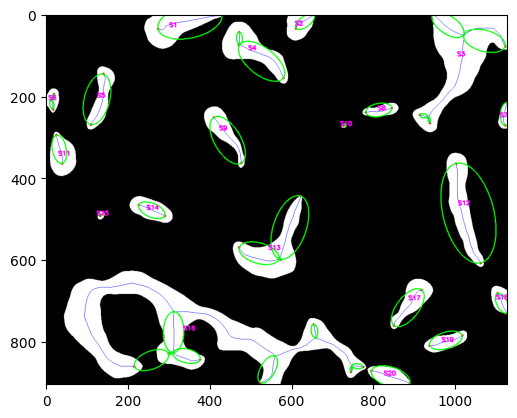

In [37]:
plt.imshow(out_img)

In [38]:

# Save CSV and image
df = pd.DataFrame(ellipse_data)
df.to_csv(save_ellipse_csv, index=False)
cv2.imwrite(save_ellipse_image, out_img)

print(f"📄 Ellipse data saved to {save_ellipse_csv}")
print(f"🖼️ Output image saved to {save_ellipse_image}")

📄 Ellipse data saved to Single_image/ellipse_image.csv
🖼️ Output image saved to Single_image/ellipse_image.png


In [39]:

def geodesic_radius(binary_img, node):
    mask = (binary_img > 0).astype(np.uint8)
    dist = distance_transform_edt(mask)
    y, x = node
    return dist[y, x]

In [40]:

def generate_unique_color(existing_colors):
    while True:
        color = tuple(random.randint(50, 255) for _ in range(3))
        if color not in existing_colors and color not in [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255)]:
            return color

In [41]:
def connect_nodes_with_geodesic_lines(image, skeleton, nodes, color=(0, 255, 255)):
    skeleton = skeleton.astype(np.uint8)
    cost_map = 1.0 - skeleton  # low cost where skeleton is present
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            start = tuple(nodes[i])
            end = tuple(nodes[j])
            try:
                path, cost = route_through_array(cost_map, start, end, fully_connected=True)
                path = np.array(path)
                if len(path) < 2 or cost > 1.5 * np.linalg.norm(np.array(start) - np.array(end)):
                    continue
                for k in range(len(path) - 1):
                    pt1 = (path[k][1], path[k][0])
                    pt2 = (path[k + 1][1], path[k + 1][0])
                    cv2.line(image, pt1, pt2, color, 1)
            except:
                continue

In [42]:
img = cv2.imread(save_binary_image, cv2.IMREAD_GRAYSCALE)
if img is None:
    print(f"Failed to load {save_binary_image}")
else:
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    labeled, num_shapes = label(binary)

    final_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    shape_data = []
    node_data = []
    existing_colors = set()
    node_id_counter = 0

    base_path = os.path.splitext(save_circle_csv)[0]

    for shape_id in range(1, num_shapes + 1):
        mask = (labeled == shape_id).astype(np.uint8) * 255
        skel = skeletonize(mask // 255)

        nodes = corner_peaks(skel.astype(np.uint8), min_distance=5, threshold_rel=0.1)
        color = generate_unique_color(existing_colors)
        existing_colors.add(color)

        shape_length = np.count_nonzero(skel)
        sorted_nodes = sorted(nodes, key=lambda p: (p[0], p[1]))  # sort by y, x

        per_shape_nodes = []

        for idx, (y, x) in enumerate(sorted_nodes):
            radius = geodesic_radius(mask, (y, x))
            node_info = {
                'node_id': node_id_counter,
                'shape_id': shape_id,
                'x': x,
                'y': y,
                'radius': radius
            }
            node_data.append(node_info)
            per_shape_nodes.append(node_info)

            cv2.circle(final_img, (x, y), int(radius), color, 1)
            cv2.circle(final_img, (x, y), 2, (0, 255, 0), -1)
            node_id_counter += 1

        # Save per-shape CSV
        per_shape_df = pd.DataFrame(per_shape_nodes)
        shape_csv_path = f"{base_path}_shape_{shape_id}_nodes.csv"
        per_shape_df.to_csv(shape_csv_path, index=False)

        # Connect nodes by geodesic paths
        connect_nodes_with_geodesic_lines(final_img, skel, sorted_nodes, color=(255, 0, 0))

        # Label center of shape
        ys, xs = np.nonzero(mask)
        if len(xs) > 0 and len(ys) > 0:
            cx = int(np.mean(xs))
            cy = int(np.mean(ys))
            cv2.putText(final_img, f'S{shape_id}', (cx - 10, cy), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 255), 2, cv2.LINE_AA)

        shape_data.append({
            'shape_id': shape_id,
            'num_nodes': len(nodes),
            'skeleton_length': shape_length
        })

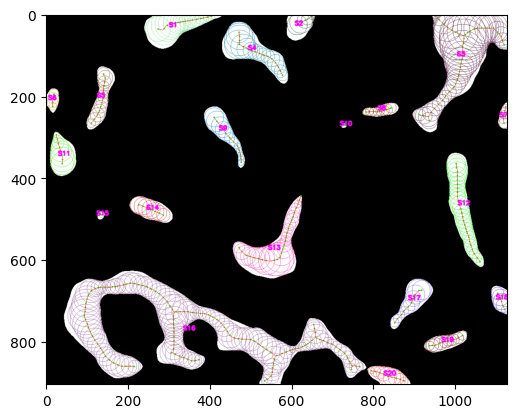

In [43]:
plt.imshow(final_img)

In [44]:
# Save final annotated image
cv2.imwrite(save_circle_image, final_img)

True

In [45]:
# Save CSVs
pd.DataFrame(node_data).to_csv(save_circle_csv.replace('.csv', '_nodes.csv'), index=False)
pd.DataFrame(shape_data).to_csv(save_circle_csv.replace('.csv', '_shapes.csv'), index=False)

print(f"🖼️ Circle Image Saved: {save_circle_image}")
print(f"📄 Node CSV Saved: {save_circle_csv.replace('.csv', '_nodes.csv')}")
print(f"📄 Shape CSV Saved: {save_circle_csv.replace('.csv', '_shapes.csv')}")

🖼️ Circle Image Saved: Single_image/circle_image.png
📄 Node CSV Saved: Single_image/circle_image_nodes.csv
📄 Shape CSV Saved: Single_image/circle_image_shapes.csv


In [46]:
circle_data = pd.read_csv("./Single_image/circle_image.csv")
ellipse_data = pd.read_csv("./Single_image/ellipse_image.csv")
all_circle_node = pd.read_csv("./Single_image/circle_image_nodes.csv")
all_node_length = pd.read_csv("./Single_image/circle_image_shapes.csv")

In [47]:
circle_data.head()

,shape_name,shape_id,node_id,x,y,radius
0,binary_image,3,1,1019,52,65.795137
1,binary_image,3,2,933,251,25.000000
2,binary_image,4,3,473,74,36.000000
3,binary_image,6,4,15,209,16.492423
4,binary_image,13,5,569,598,40.162171


In [48]:
max_shape_id = max(
    circle_data['shape_id'].max(),
    ellipse_data['shape_id'].max(),
    all_circle_node['shape_id'].max()
)
shape_ids = list(range(1, max_shape_id + 1))

In [49]:
avg_radius_per_shape = circle_data.groupby('shape_id')['radius'].mean()
overall_avg_radius = circle_data['radius'].mean()
avg_radius_per_shape_filled = avg_radius_per_shape.reindex(shape_ids).fillna(overall_avg_radius)
avg_radius_per_shape_filled_array = avg_radius_per_shape_filled.reset_index().values
avg_radius_per_shape_filled_array


array([[ 1.        , 34.06564399],
       [ 2.        , 34.06564399],
       [ 3.        , 45.3975683 ],
       [ 4.        , 36.        ],
       [ 5.        , 34.06564399],
       [ 6.        , 16.4924225 ],
       [ 7.        , 34.06564399],
       [ 8.        , 34.06564399],
       [ 9.        , 34.06564399],
       [10.        , 34.06564399],
       [11.        , 34.06564399],
       [12.        , 34.06564399],
       [13.        , 40.16217126],
       [14.        , 34.06564399],
       [15.        , 34.06564399],
       [16.        , 31.44134191],
       [17.        , 34.06564399],
       [18.        , 34.06564399],
       [19.        , 34.06564399],
       [20.        , 34.06564399]])

In [50]:
ellipse_data.head()

,shape_name,shape_id,pair_id,x,y,semi_major,semi_minor,angle
0,binary_image,1,1,351,18,80.049984,40.024992,167.005383
1,binary_image,2,2,632,18,27.500000,13.750000,143.130102
2,binary_image,3,3,981,26,45.348649,22.674325,34.215702
3,binary_image,3,4,935,258,7.762087,3.881044,75.068583
4,binary_image,3,5,1070,65,52.756516,26.378258,14.826480


In [51]:
avg_ellipse_per_shape = ellipse_data.groupby('shape_id')['semi_major'].mean()
overall_avg_semi_major = ellipse_data['semi_major'].mean()
avg_ellipse_per_shape_filled = avg_ellipse_per_shape.reindex(shape_ids).fillna(overall_avg_semi_major)
avg_ellipse_per_shape_filled_array = avg_ellipse_per_shape_filled.reset_index().values
avg_ellipse_per_shape_filled_array


array([[  1.        ,  80.04998438],
       [  2.        ,  27.5       ],
       [  3.        ,  29.16519237],
       [  4.        ,  27.87396583],
       [  5.        ,  63.9081372 ],
       [  6.        ,   6.87661701],
       [  7.        ,  28.11138559],
       [  8.        ,  32.46921619],
       [  9.        ,  65.        ],
       [ 10.        ,   2.91547595],
       [ 11.        ,  35.6931366 ],
       [ 12.        , 125.1489113 ],
       [ 13.        ,  44.87644153],
       [ 14.        ,  34.73110997],
       [ 15.        ,   2.12132034],
       [ 16.        ,  26.2664395 ],
       [ 17.        ,  55.21095906],
       [ 18.        ,  26.61296676],
       [ 19.        ,  41.90763654],
       [ 20.        ,  49.48989796]])

In [52]:
all_circle_node.head()

,node_id,shape_id,x,y,radius
0,0,1,404,5,8.944272
1,1,1,394,7,11.661904
2,2,1,384,9,13.928388
3,3,1,378,10,15.652476
4,4,1,368,12,18.027756


In [53]:
avg_node_radius_per_shape = all_circle_node.groupby('shape_id')['radius'].mean()
overall_avg_node_radius = all_circle_node['radius'].mean()
avg_node_radius_per_shape_filled = avg_node_radius_per_shape.reindex(shape_ids).fillna(overall_avg_node_radius)
avg_node_radius_per_shape_filled_array = avg_node_radius_per_shape_filled.reset_index().values
avg_node_radius_per_shape_filled_array


array([[ 1.        , 25.53889378],
       [ 2.        , 19.51836096],
       [ 3.        , 34.67745941],
       [ 4.        , 23.61735543],
       [ 5.        , 15.07645582],
       [ 6.        , 12.86987999],
       [ 7.        , 10.61208504],
       [ 8.        , 11.3992889 ],
       [ 9.        , 14.56323666],
       [10.        ,  3.60555128],
       [11.        , 21.19595399],
       [12.        , 19.14001967],
       [13.        , 20.97552488],
       [14.        , 21.40366247],
       [15.        ,  7.61577311],
       [16.        , 24.46460123],
       [17.        , 17.94875774],
       [18.        , 17.23349846],
       [19.        , 14.99600381],
       [20.        , 16.59243444]])

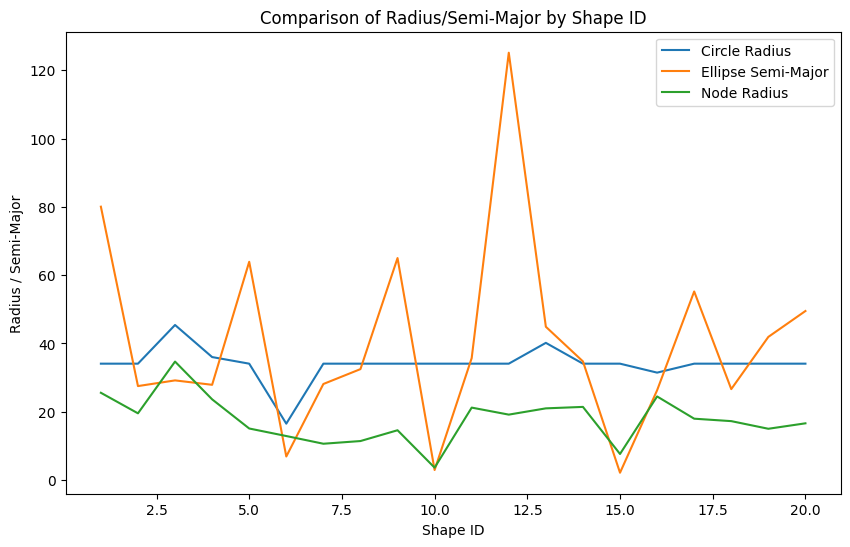

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(avg_radius_per_shape_filled_array[:, 0], avg_radius_per_shape_filled_array[:, 1], label='Circle Radius')
plt.plot(avg_ellipse_per_shape_filled_array[:, 0], avg_ellipse_per_shape_filled_array[:, 1], label='Ellipse Semi-Major')
plt.plot(avg_node_radius_per_shape_filled_array[:, 0], avg_node_radius_per_shape_filled_array[:, 1], label='Node Radius')
plt.xlabel('Shape ID')
plt.ylabel('Radius / Semi-Major')
plt.title('Comparison of Radius/Semi-Major by Shape ID')
plt.legend()
plt.show()

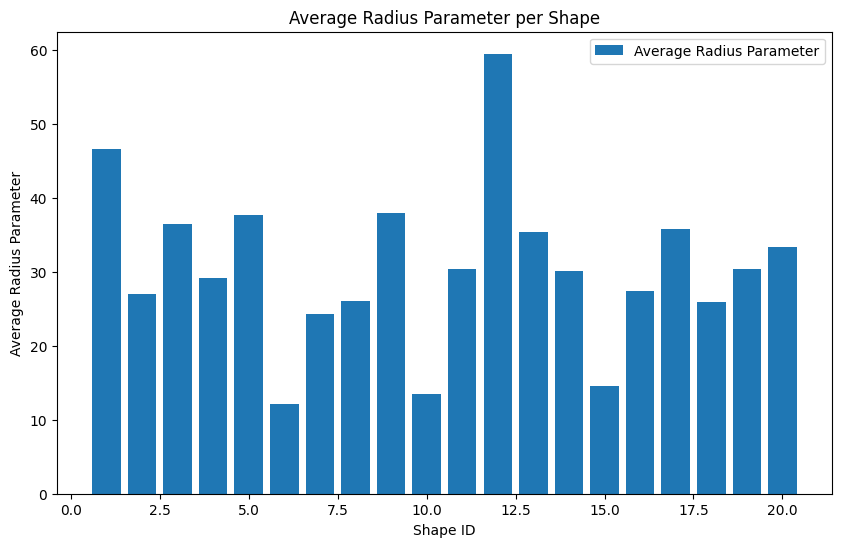

In [55]:
avg_circle_list = [avg_radius_per_shape_filled.get(sid, float('nan')) for sid in shape_ids]
avg_ellipse_list = [avg_ellipse_per_shape_filled.get(sid, float('nan')) for sid in shape_ids]
avg_node_list = [avg_node_radius_per_shape_filled.get(sid, float('nan')) for sid in shape_ids]

average_radius_param_per_shape = [(c + e + n) / 3 for c, e, n in zip(avg_circle_list, avg_ellipse_list, avg_node_list)]

plt.figure(figsize=(10, 6))
plt.bar(shape_ids, average_radius_param_per_shape, label='Average Radius Parameter')
plt.xlabel('Shape ID')
plt.ylabel('Average Radius Parameter')
plt.title('Average Radius Parameter per Shape')
plt.legend()
plt.show()

Find the Volume of each shape and store the volume of each shape

In [56]:
# Restore the original label function
from scipy.ndimage import label

# Define pixel area if not already defined
pixel_area = 1.0

# Label connected components in the binary image
labeled, num_shapes = label(binary_image)

# Store results
shape_areas = []

for shape_id in range(1, num_shapes + 1):
    shape_mask = labeled == shape_id
    pixel_count = np.count_nonzero(shape_mask)
    volume = pixel_count * pixel_area

    shape_areas.append({
        'shape_id': shape_id,
        'pixel_count': pixel_count,
        'volume': volume
    })

# Convert to DataFrame and save to CSV
df = pd.DataFrame(shape_areas)
df.to_csv(save_volume, index=False)

# Print summary
print(df)
print(f"✅ Found {num_shapes} shapes")
print(f"📄 Volume data saved to {save_volume}")


    shape_id  pixel_count   volume
0          1         8943   8943.0
1          2         3519   3519.0
2          3        29225  29225.0
3          4        10569  10569.0
4          5         5139   5139.0
5          6         1434   1434.0
6          7         1170   1170.0
7          8         2001   2001.0
8          9         5310   5310.0
9         10          112    112.0
10        11         5127   5127.0
11        12        11112  11112.0
12        13        13987  13987.0
13        14         4398   4398.0
14        15          277    277.0
15        16        68023  68023.0
16        17         5456   5456.0
17        18         2279   2279.0
18        19         3332   3332.0
19        20         3315   3315.0
✅ Found 20 shapes
📄 Volume data saved to Single_image/volume.csv


In [57]:
df['volume'].describe()

count       20.000000
mean      9236.400000
std      15326.259283
min        112.000000
25%       2209.500000
50%       4762.500000
75%       9349.500000
max      68023.000000
Name: volume, dtype: float64

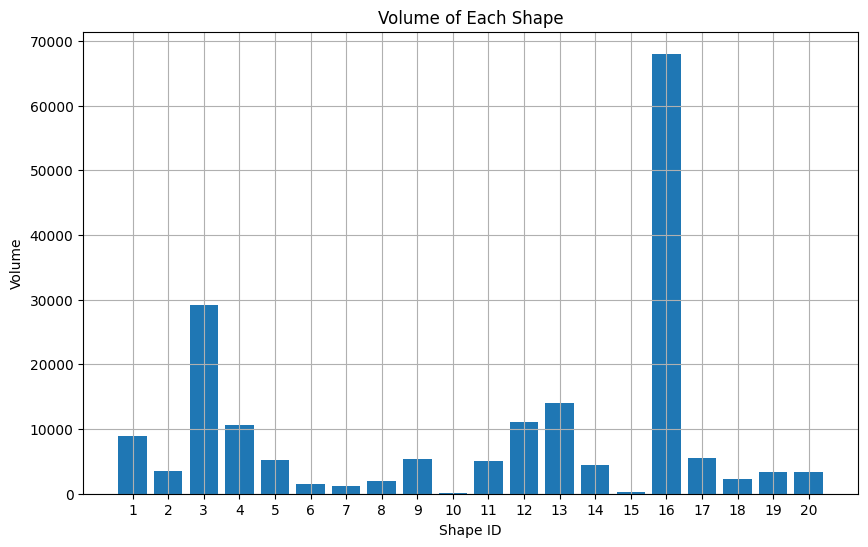

In [58]:
plt.figure(figsize=(10, 6))
plt.bar(df['shape_id'], df['volume'])
plt.xlabel('Shape ID')
plt.grid()
plt.ylabel('Volume')
plt.title('Volume of Each Shape')
plt.xticks(df['shape_id'])  # Show all shape IDs as integer ticks
plt.show()

In [59]:
all_node_length.head()

,shape_id,num_nodes,skeleton_length
0,1,17,159
1,2,5,53
2,3,43,431
3,4,16,159
4,5,13,125


In [60]:
all_node_length.describe()

,shape_id,num_nodes,skeleton_length
count,20.00000,20.000000,20.000000
mean,10.50000,17.400000,169.900000
std,5.91608,26.786485,267.649201
min,1.00000,1.000000,4.000000
25%,5.75000,5.000000,56.000000
50%,10.50000,9.500000,88.000000
75%,15.25000,16.250000,159.000000
max,20.00000,123.000000,1224.000000


In [61]:
total_length_of_bone = sum(all_node_length["skeleton_length"])
print("Total Bone length in a image", total_length_of_bone)

Total Bone length in a image 3398


  Found 10 total nodes and 20 shapes in the image.
✅ Ellipse placement complete. Placed 17 ellipses.
📄 Ellipse data saved to Single_image/ellipse_image.csv
🖼️ Output image saved to Single_image/ellipse_image.png


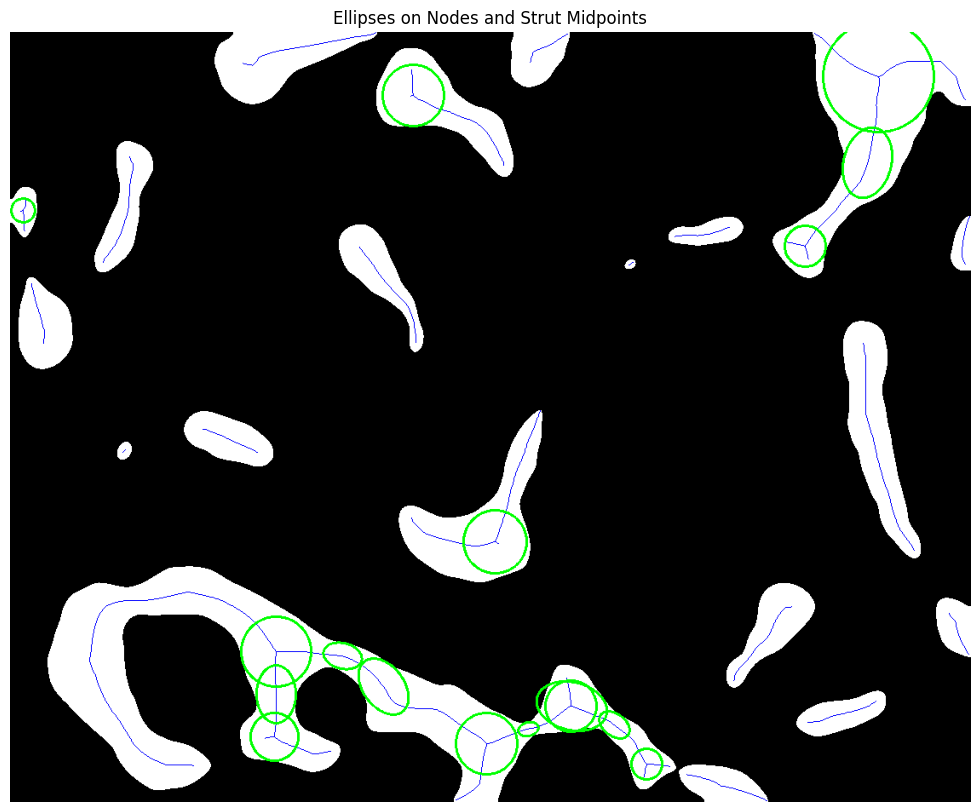

In [90]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

from skimage.morphology import skeletonize
from scipy.ndimage import convolve, label, center_of_mass, distance_transform_edt

# --- Helper Functions ---
def angle_between(p1, p2):
    """Calculates the angle of the line connecting two points."""
    dy = p2[0] - p1[0]
    dx = p2[1] - p1[1]
    return np.degrees(np.arctan2(dy, dx))

# --- Main Ellipse Fitting Block ---

# 1. Prepare inputs from previous notebook cells
if 'binary_image' not in locals():
    raise NameError("The 'binary_image' variable is not defined. Please run the binarization cell first.")

bw = (binary_image > 0).astype(np.uint8)
shape_name = os.path.splitext(os.path.basename(input_image))[0] if 'input_image' in locals() else "bone_image"
labeled, num_shapes = label(bw)
out_img = cv2.cvtColor((bw * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Calculate a distance map for accurate width measurements
dist_map = distance_transform_edt(bw)

# 2. Perform skeletonization and find nodes
skel = skeletonize(bw).astype(np.uint8)
deg = convolve(skel, np.ones((3, 3), np.uint8), mode='constant', cval=0) - skel
node_mask = (skel == 1) & (deg >= 3)
lbl_nodes, n_nodes = label(node_mask)
centroids = center_of_mass(node_mask, lbl_nodes, range(1, n_nodes + 1))
nodes = [(int(round(r)), int(round(c))) for r, c in centroids]

print(f"  Found {len(nodes)} total nodes and {num_shapes} shapes in the image.")

# Optional: Draw the skeleton for context
ys, xs = np.where(skel)
out_img[ys, xs] = (255, 0, 0) # Blue skeleton

# 3. Initialize data storage
ellipse_data = []
processed_pairs = set()

# 4. Iterate through each shape to place ellipses
for shape_id in range(1, num_shapes + 1):
    mask = (labeled == shape_id)
    shape_skel = (skel * mask).astype(np.uint8)
    region_nodes = [p for p in nodes if mask[p]]
    region_nodes_set = set(region_nodes)
    
    # --- Draw ACCURATE Ellipses (Circles) on Nodes ---
    for r_node, c_node in region_nodes:
        branch_widths = []
        # Explore each of the 8 neighbors to find starting points of branches
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0: continue
                nr, nc = r_node + dr, c_node + dc

                if 0 <= nr < shape_skel.shape[0] and 0 <= nc < shape_skel.shape[1] and shape_skel[nr, nc]:
                    # Trace this branch for a short distance to find its width
                    branch_path = [(r_node, c_node), (nr, nc)]
                    visited_branch = set(branch_path)
                    q = deque([(nr, nc)])
                    
                    while q and len(branch_path) < 10: # Trace up to 10 pixels
                        r_curr, c_curr = q.popleft()
                        found_next = False
                        for dr_b in [-1, 0, 1]:
                            for dc_b in [-1, 0, 1]:
                                if dr_b == 0 and dc_b == 0: continue
                                nr_b, nc_b = r_curr + dr_b, c_curr + dc_b
                                if 0 <= nr_b < shape_skel.shape[0] and 0 <= nc_b < shape_skel.shape[1] and \
                                   shape_skel[nr_b, nc_b] and (nr_b, nc_b) not in visited_branch:
                                    branch_path.append((nr_b, nc_b))
                                    visited_branch.add((nr_b, nc_b))
                                    q.append((nr_b, nc_b))
                                    found_next = True
                                    break
                            if found_next: break
                    
                    # Calculate the average thickness of this branch
                    if len(branch_path) > 2:
                        thicknesses = [dist_map[py, px] for py, px in branch_path[1:]] # Exclude node center
                        branch_widths.append(np.mean(thicknesses))

        # Average the widths of all branches to get the node's representative radius
        if branch_widths:
            avg_radius = int(np.mean(branch_widths))
            ellipse_data.append({
                'shape_id': shape_id, 'type': 'node', 'x': c_node, 'y': r_node,
                'semi_major': avg_radius, 'semi_minor': avg_radius, 'angle': 0
            })
            # Draw a green circle on the node with the calculated average radius
            cv2.ellipse(out_img, (c_node, r_node), (avg_radius, avg_radius), 0, 0, 360, (0, 255, 0), 2)

    # --- Find and Draw Ellipses on Midpoints between Nodes ---
    for p1 in region_nodes:
        queue = deque([(p1, [p1])])
        visited_pixels = {p1}

        while queue:
            (r, c), path = queue.popleft()
            if (r, c) != p1 and (r, c) in region_nodes_set:
                p2 = (r, c)
                pair = tuple(sorted((p1, p2)))

                if pair not in processed_pairs:
                    processed_pairs.add(pair)
                    mid_point_on_path = path[len(path) // 2]
                    my, mx = mid_point_on_path
                    semi_minor = dist_map[my, mx]
                    semi_major = semi_minor * 1.5
                    
                    p_before = path[max(0, len(path) // 2 - 2)]
                    p_after = path[min(len(path) - 1, len(path) // 2 + 2)]
                    angle = angle_between(p_before, p_after)

                    ellipse_data.append({
                        'shape_id': shape_id, 'type': 'midpoint', 'x': mx, 'y': my,
                        'semi_major': semi_major, 'semi_minor': semi_minor, 'angle': angle
                    })
                    # Draw a green ellipse on the midpoint
                    cv2.ellipse(out_img, (mx, my), (int(semi_major), int(semi_minor)),
                                angle, 0, 360, (0, 255, 0), 2)
                continue

            for dr in [-1, 0, 1]:
                for dc in [-1, 0, 1]:
                    if dr == 0 and dc == 0: continue
                    nr, nc = r + dr, c + dc
                    if 0 <= nr < shape_skel.shape[0] and 0 <= nc < shape_skel.shape[1] and \
                       shape_skel[nr, nc] and (nr, nc) not in visited_pixels:
                        visited_pixels.add((nr, nc))
                        queue.append(((nr, nc), path + [(nr, nc)]))
    
# 5. Save and display the final results
df_ellipse = pd.DataFrame(ellipse_data)
df_ellipse.to_csv(save_ellipse_csv, index=False)
cv2.imwrite(save_ellipse_image, out_img)

print(f"✅ Ellipse placement complete. Placed {len(df_ellipse)} ellipses.")
print(f"📄 Ellipse data saved to {save_ellipse_csv}")
print(f"🖼️ Output image saved to {save_ellipse_image}")

# Display the final image in the notebook
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.title("Ellipses on Nodes and Strut Midpoints")
plt.axis('off')
plt.show()